# COVID-19 Prediction Model with Enhanced Techniques

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:

train_files = ['lbp-train-fold_0.csv', 'lbp-train-fold_1.csv', 'lbp-train-fold_2.csv', 'lbp-train-fold_3.csv', 'lbp-train-fold_4.csv']
test_file = 'lbp-test.csv'


train_dfs = [pd.read_csv(file) for file in train_files]
df = pd.concat(train_dfs, ignore_index=True)


test_df = pd.read_csv(test_file)


attribute_columns = [f'attribute{i}' for i in range(1, 60)]
target_column = 'class'


X = df[attribute_columns]
y = df[target_column]
X_test = test_df[attribute_columns]
y_test = test_df[target_column]

In [33]:

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [34]:

selector = SelectKBest(score_func=f_classif, k=5) 
X_resampled = selector.fit_transform(X_resampled, y_resampled)
X_test_selected = selector.transform(X_test) 


In [35]:


param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)


best_params = grid_search.best_params_
print("Best Parameters: ", best_params)
print("Best Cross-Validation Score: ", grid_search.best_score_)


Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score:  0.9230612244897959


Random Forest Accuracy:  0.847953216374269
Confusion Matrix:
 [[273  17   1   0   0   4   5]
 [  5  17   0   0   1   3   1]
 [  0   2   0   0   0   1   0]
 [  1   2   0   0   0   0   0]
 [  0   1   1   0   0   1   0]
 [  2   1   0   0   0   0   0]
 [  0   2   0   0   1   0   0]]


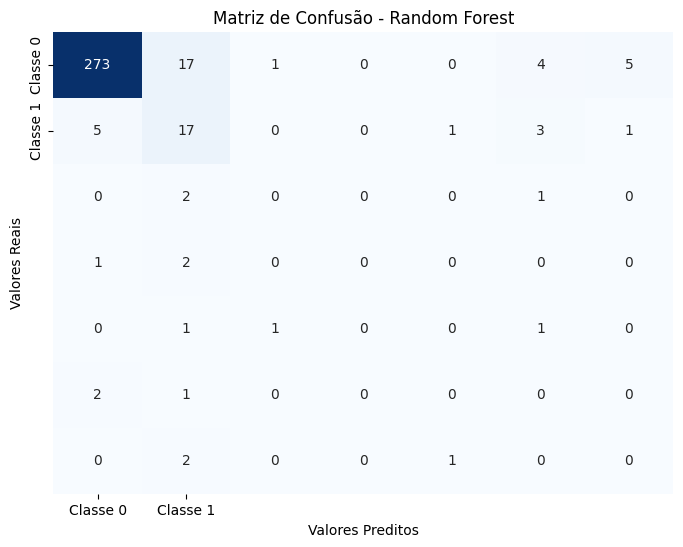

In [36]:

rf = RandomForestClassifier(n_estimators=100, random_state=42, **best_params)
rf.fit(X_resampled, y_resampled)
y_pred_rf = rf.predict(X_test_selected)



accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Accuracy: ", accuracy_rf)
print("Confusion Matrix:\n", conf_matrix_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("Matriz de Confusão - Random Forest")
plt.ylabel("Valores Reais")
plt.xlabel("Valores Preditos")
plt.show()
